## Setup
We need an available Java installation to run pyspark. The easiest way to do this is to install JDK and set the proper paths using conda

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.2.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [3]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3fa0670e-1f15-4929-827a-c656288f4e27;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 309ms :: artifacts dl 23ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

3.2.0


In [6]:
%%time
import time
import sagemaker
from sagemaker.spark.processing import PySparkProcessor

# Setup the PySpark processor to run the job. Note the instance type and instance count parameters. SageMaker will create these many instances of this type for the spark job.
role = sagemaker.get_execution_role()
spark_processor = PySparkProcessor(
    base_job_name="sm-spark-project",
    framework_version="3.3",
    role=role,
    instance_count=8,
    instance_type="ml.m5.xlarge",
    max_runtime_in_seconds=3600,
)

# s3 paths
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_logs = f"spark_logs"

# modify this comma separated list to choose the subreddits of interest
subreddits = "socialism, Economics"
configuration = [
    {
        "Classification": "spark-defaults",
        "Properties": {"spark.executor.memory": "12g", "spark.executor.cores": "4"},
    }
]


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
CPU times: user 2.43 s, sys: 402 ms, total: 2.83 s
Wall time: 2.78 s


## Process S3 data with SageMaker Processing Job `PySparkProcessor`

We are going to move the above processing code in a Python file and then submit that file to SageMaker Processing Job's [`PySparkProcessor`](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_processing.html#pysparkprocessor).

In [7]:
%%time
output_prefix_data_submissions = f"project/submissions/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"
print(f"reading submissions from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")

reading submissions from s3a://sagemaker-us-east-1-019290627849/project/submissions/yyyy=*


23/11/30 20:41:30 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
23/11/30 20:41:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


shape of the submissions dataframe is 34,345x68
CPU times: user 22.2 ms, sys: 4.46 ms, total: 26.6 ms
Wall time: 40 s


In [8]:
# check counts (ensuring all needed subreddits exist)
submissions.groupBy('subreddit').count().show()

+---------+-----+
|subreddit|count|
+---------+-----+
|   soccer|34345|
+---------+-----+



In [9]:
# display a subset of columns
df = submissions.select("title", "created_utc", "score", "num_comments", "num_crossposts", "is_video", "over_18", "distinguished", "preview", "media").cache()
df.show()

+--------------------+-------------------+-----+------------+--------------+--------+-------+-------------+--------------------+--------------------+
|               title|        created_utc|score|num_comments|num_crossposts|is_video|over_18|distinguished|             preview|               media|
+--------------------+-------------------+-----+------------+--------------+--------+-------+-------------+--------------------+--------------------+
|[Sky Sports Footb...|2023-01-19 15:13:46|    1|           1|             0|   false|  false|         null|                null|{null, {Sky Sport...|
|[Portsmouth News]...|2023-01-19 15:16:17|  555|          85|             0|   false|  false|         null|                null|                null|
|Jonas Omlin signi...|2023-01-19 15:23:57|   96|          12|             0|   false|  false|         null|{false, [{yVBwrxA...|                null|
|EFL: Championship...|2023-01-19 15:28:04|   33|          14|             0|   false|  false|       

In [10]:
from pyspark.sql.functions import explode, col, size, split, col, hour, from_utc_timestamp, when, coalesce, lit

# get columns from the second layer of the schema
df_cleaned = df.withColumn("preview_enabled", col("preview.enabled")).withColumn("duration", col("media.reddit_video.duration"))\
    .drop("preview", "media").cache()

# get the length of title
df_cleaned = df_cleaned.withColumn("title_length", size(split(df["title"], " "))).drop("title", "")

# get the time of publish
df_cleaned = df_cleaned.withColumn("night", when((hour(col("created_utc")) >= 3) & (hour(col("created_utc")) < 18), False).otherwise(True))\
    .drop("created_utc").withColumn("distinguished", when(col("distinguished").isNull(), False).otherwise(True))

# define the target column
df_cleaned = df_cleaned.withColumn("popular", when(df["num_comments"] > 20, 1).otherwise(0)).cache()

# replace the null values
df_cleaned = df_cleaned.withColumn("duration", coalesce(df_cleaned["duration"], lit(0)))\
    .withColumn("preview_enabled", coalesce(df_cleaned["preview_enabled"], lit(False))).cache()

df_cleaned.show()

+-----+------------+--------------+--------+-------+-------------+---------------+--------+------------+-----+-------+
|score|num_comments|num_crossposts|is_video|over_18|distinguished|preview_enabled|duration|title_length|night|popular|
+-----+------------+--------------+--------+-------+-------------+---------------+--------+------------+-----+-------+
|    1|           1|             0|   false|  false|        false|          false|       0|          14|false|      0|
|  555|          85|             0|   false|  false|        false|          false|       0|          12|false|      1|
|   96|          12|             0|   false|  false|        false|          false|       0|           8|false|      0|
|   33|          14|             0|   false|  false|        false|          false|       0|          15|false|      0|
|   10|           3|             0|    true|  false|        false|          false|      39|          21|false|      0|
|    1|           1|             0|   false|  fa

In [11]:
from pyspark.ml.feature import VectorAssembler, IndexToString, StringIndexer
from pyspark.ml.classification  import RandomForestClassifier
from pyspark.ml import Pipeline

# drop extra columns
df_num = df_cleaned.drop("duration", "num_comments")

# assemble all variables for training
feature_list = []
for col in df_num.columns:
    if col == 'popular':
        continue
    else:
        feature_list.append(col)
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

# create a random forest model
rf = RandomForestClassifier(labelCol="popular", featuresCol="features")

# create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

In [12]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np

# create a parameter map for grid search
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

# implement crossvalidation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="popular"),
                          numFolds=5)

In [13]:
# split the dataset
(trainingData, testData) = df_num.randomSplit([0.8, 0.2])

# train the data with training set and get predictions of test set
cvModel = crossval.fit(trainingData)
predictions = cvModel.transform(testData)

23/11/30 20:43:35 WARN DAGScheduler: Broadcasting large task binary with size 1291.7 KiB
23/11/30 20:43:36 WARN DAGScheduler: Broadcasting large task binary with size 1629.6 KiB
23/11/30 20:43:37 WARN DAGScheduler: Broadcasting large task binary with size 1945.5 KiB
23/11/30 20:43:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/11/30 20:43:39 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/11/30 20:43:40 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/11/30 20:43:41 WARN DAGScheduler: Broadcasting large task binary with size 1039.1 KiB
23/11/30 20:43:45 WARN DAGScheduler: Broadcasting large task binary with size 1291.7 KiB
23/11/30 20:43:46 WARN DAGScheduler: Broadcasting large task binary with size 1629.6 KiB
23/11/30 20:43:46 WARN DAGScheduler: Broadcasting large task binary with size 1945.5 KiB
23/11/30 20:43:48 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/11/30 20:43:49 WARN DAGSchedul

In [14]:
# get the accuracy of prediction
evaluator = MulticlassClassificationEvaluator()
evaluator.setPredictionCol("prediction")
evaluator.setLabelCol("popular")
evaluator.evaluate(predictions)

23/11/30 20:49:40 WARN DAGScheduler: Broadcasting large task binary with size 1633.4 KiB


0.889344592828071

In [15]:
# check parameters of the model selected by grid search
model = cvModel.bestModel.stages[-1]
model

RandomForestClassificationModel: uid=RandomForestClassifier_c2d02e8d046f, numTrees=50, numClasses=2, numFeatures=8

In [16]:
model.getMaxDepth()

15

In [17]:
# get the feature importance of the model
importances = model.featureImportances

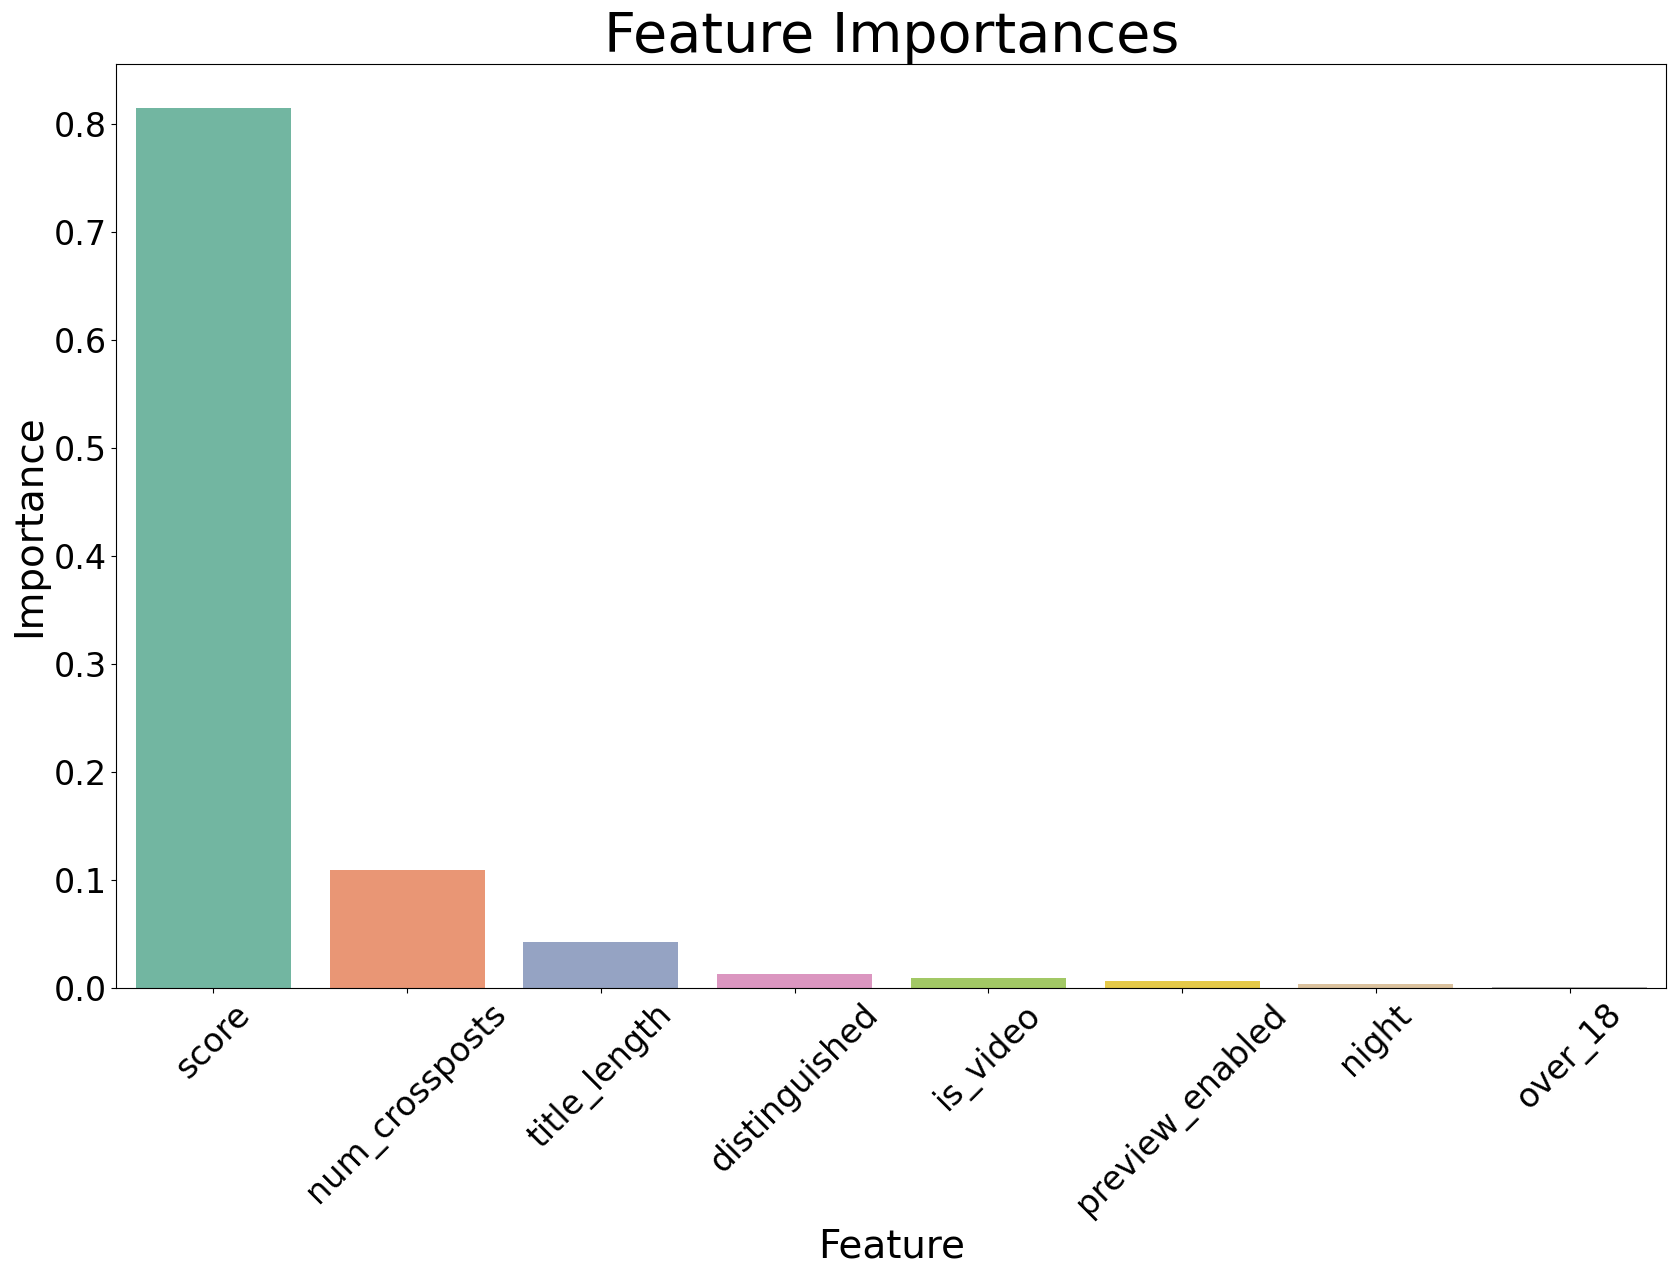

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

importance_values = importances.toArray()
sorted_importances, sorted_features = zip(*sorted(zip(importance_values, feature_list), reverse=True))

# Creating the bar plot
plt.figure(figsize=(20, 12))
sns.barplot(x=list(sorted_features), y=list(sorted_importances), palette='Set2')
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=24)
plt.ylabel('Importance', fontsize=28)
plt.xlabel('Feature', fontsize=28)
plt.title('Feature Importances', fontsize=40)
plt.show()

In [19]:
# save self-trained random forest model to local
cvModel.bestModel.save("../../model/random forest")

In [22]:
# create a new test set and save it as par
(trainingData_new, testData_new) = df_num.randomSplit([0.8, 0.2])
testData_new.write.parquet("../../data/parquet/")